# Environmental Sound Classification using Deep Learning - <ins>Keras</ins>
## >> Urban sound classification with CNNs

* [0. Load the preprocessed data](#zero-bullet)
* [1. Data augmentation](#first-bullet)
* [2. CNN model](#second-bullet)
* [3. Helper functions](#third-bullet)
* [4. 10-Fold Cross Validation](#fourth-bullet)
* [5. Results](#fifth-bullet)

---

In [1]:
import numpy as np
import pandas as pd

from keras import regularizers, activations
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils, to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime 

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
USE_GOOGLE_COLAB = True

if USE_GOOGLE_COLAB:
    from google.colab import drive 
    drive.mount('/content/gdrive')

    # change the current working directory
    %cd gdrive/'My Drive'/US8K
else:
    %cd US8K

Mounted at /content/gdrive
/content/gdrive/My Drive/US8K


---

## 0. Load the preprocessed data <a name="zero-bullet"></a>

In [3]:
us8k_df = pd.read_pickle("us8k_df.pkl")

In [4]:
us8k_df.head()

,melspectrogram,label,fold
0,"[[-61.70703, -74.49714, -65.133354, -65.751175...",3,5
1,"[[-11.593532, -3.6112566, -12.501208, -13.6347...",2,5
2,"[[-24.203024, -14.915937, -6.091387, -12.99589...",2,5
3,"[[-15.058913, -12.812816, -12.299819, -11.4387...",2,5
4,"[[-9.8777, 0.0, -11.115205, -10.564414, -3.854...",2,5


---

## 1. Data augmentation <a name="first-bullet"></a>

In [5]:
def init_data_aug():
    train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval=-80.0,
        width_shift_range=0.1,
        height_shift_range=0.0)

    val_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval=-80.0)
    
    return train_datagen, val_datagen

---

## 2. CNN model  <a name="second-bullet"></a>


In [6]:
def init_model():
    model1 = Sequential()
    
    #layer-1
    model1.add(Conv2D(filters=24, kernel_size=5, input_shape=(128, 128, 1),
                      kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(3,3), strides=3))
    model1.add(Activation(activations.relu))
    
    #layer-2
    model1.add(Conv2D(filters=36, kernel_size=4, padding='valid', kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model1.add(Activation(activations.relu))
    
    #layer-3
    model1.add(Conv2D(filters=48, kernel_size=3, padding='valid'))
    model1.add(Activation(activations.relu))
    
    model1.add(GlobalAveragePooling2D())
    
    #layer-4 (1st dense layer)
    model1.add(Dense(60, activation='relu'))
    model1.add(Dropout(0.5))
    
    #layer-5 (2nd dense layer)
    model1.add(Dense(10, activation='softmax'))

    
    # compile
    model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model1

In [7]:
model = init_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 24)      624       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 41, 24)        0         
_________________________________________________________________
activation (Activation)      (None, 41, 41, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 36)        13860     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 36)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 19, 19, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 48)        1

---

## 3. Helper functions  <a name="third-bullet"></a>

In [8]:
def train_test_split(fold_k, data, X_dim=(128, 128, 1)):
    X_train = np.stack(data[data.fold != fold_k].melspectrogram.to_numpy())
    X_test = np.stack(data[data.fold == fold_k].melspectrogram.to_numpy())

    y_train = data[data.fold != fold_k].label.to_numpy()
    y_test = data[data.fold == fold_k].label.to_numpy()

    XX_train = X_train.reshape(X_train.shape[0], *X_dim)
    XX_test = X_test.reshape(X_test.shape[0], *X_dim)
    
    yy_train = to_categorical(y_train)
    yy_test = to_categorical(y_test)
    
    return XX_train, XX_test, yy_train, yy_test

In [9]:
def process_fold(fold_k, data, epochs=100, num_batch_size=32):
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(fold_k, data)

    # init data augmention
    train_datagen, val_datagen = init_data_aug()
    
    # fit augmentation
    train_datagen.fit(X_train)
    val_datagen.fit(X_train)

    # init model
    model = init_model()

    # pre-training accuracy
    score = model.evaluate(val_datagen.flow(X_test, y_test, batch_size=num_batch_size), verbose=0)
    print("Pre-training accuracy: %.4f%%\n" % (100 * score[1]))
    
    # train the model
    start = datetime.now()
    history = model.fit(train_datagen.flow(X_train, y_train, batch_size=num_batch_size), 
                        steps_per_epoch=len(X_train) / num_batch_size, 
                        epochs=epochs, 
                        validation_data=val_datagen.flow(X_test, y_test, batch_size=num_batch_size))
    end = datetime.now()
    print("Training completed in time: ", end - start, '\n')
    
    return history

In [10]:
def show_results(tot_history):
    """Show accuracy and loss graphs for train and test sets."""

    for i, history in enumerate(tot_history):
        print('\n({})'.format(i+1))

        plt.figure(figsize=(15,5))

        plt.subplot(121)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.grid(linestyle='--')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(122)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.grid(linestyle='--')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')
            
        plt.show()

        print('\tMax validation accuracy: %.4f %%' % (np.max(history.history['val_accuracy']) * 100))
        print('\tMin validation loss: %.5f' % np.min(history.history['val_loss']))

---

## 4. 10-Fold Cross Validation  <a name="fourth-bullet"></a>

* [fold-1](#fold-1)
* [fold-2](#fold-2)
* [fold-3](#fold-3)
* [fold-4](#fold-4)
* [fold-5](#fold-5)
* [fold-6](#fold-6)
* [fold-7](#fold-7)
* [fold-8](#fold-8)
* [fold-9](#fold-9)
* [fold-10](#fold-10)

### fold-1 <a name="fold-1"></a>

In [24]:
FOLD_K = 1
REPEAT = 1

history1 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history1.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 2.8637%

Epoch 1/100
246/245 [==============================] - 11s 44ms/step - loss: 2.0781 - accuracy: 0.2257 - val_loss: 1.7888 - val_accuracy: 0.3058
Epoch 2/100
246/245 [==============================] - 11s 44ms/step - loss: 1.8673 - accuracy: 0.2980 - val_loss: 1.6559 - val_accuracy: 0.3677
Epoch 3/100
246/245 [==============================] - 11s 44ms/step - loss: 1.7244 - accuracy: 0.3640 - val_loss: 1.4030 - val_accuracy: 0.4502
Epoch 4/100
246/245 [==============================] - 11s 44ms/step - loss: 1.5954 - accuracy: 0.4185 - val_loss: 1.3822 - val_accuracy: 0.4548
Epoch 5/100
246/245 [==============================] - 11s 44ms/step - loss: 1.5095 - accuracy: 0.4495 - val_loss: 1.2706 - val_accuracy: 0.5475
Epoch 6/100
246/245 [==============================] - 11s 44ms/step - loss: 1.4303 - accuracy: 0.4816 - val_loss: 1.2291 - val_accuracy: 0.4914
Epoch 7/100


(1)


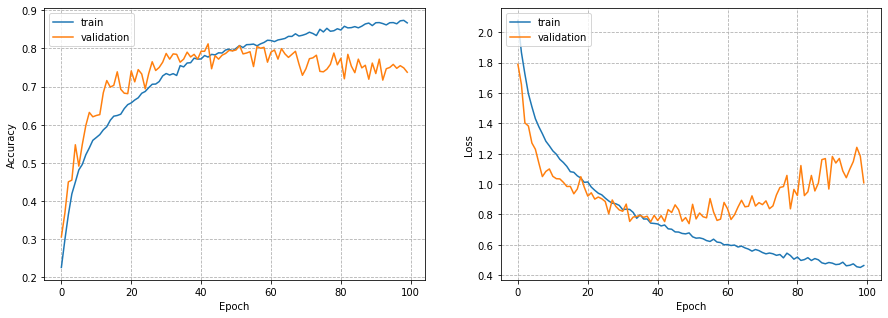

	Max validation accuracy: 81.2142 %
	Min validation loss: 0.73915


In [25]:
show_results(history1)

### fold-2 <a name="fold-2"></a>

In [26]:
FOLD_K = 2
REPEAT = 1

history2 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history2.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 14.1892%

Epoch 1/100
246/245 [==============================] - 10s 41ms/step - loss: 2.0893 - accuracy: 0.2235 - val_loss: 1.8992 - val_accuracy: 0.2354
Epoch 2/100
246/245 [==============================] - 10s 41ms/step - loss: 1.9092 - accuracy: 0.2708 - val_loss: 1.7946 - val_accuracy: 0.2354
Epoch 3/100
246/245 [==============================] - 10s 42ms/step - loss: 1.8013 - accuracy: 0.3146 - val_loss: 1.6632 - val_accuracy: 0.3604
Epoch 4/100
246/245 [==============================] - 10s 41ms/step - loss: 1.6710 - accuracy: 0.3877 - val_loss: 1.5538 - val_accuracy: 0.3333
Epoch 5/100
246/245 [==============================] - 10s 41ms/step - loss: 1.5538 - accuracy: 0.4326 - val_loss: 1.4228 - val_accuracy: 0.4212
Epoch 6/100
246/245 [==============================] - 10s 41ms/step - loss: 1.4486 - accuracy: 0.4786 - val_loss: 1.4721 - val_accuracy: 0.4313
Epoch 7/10


(1)


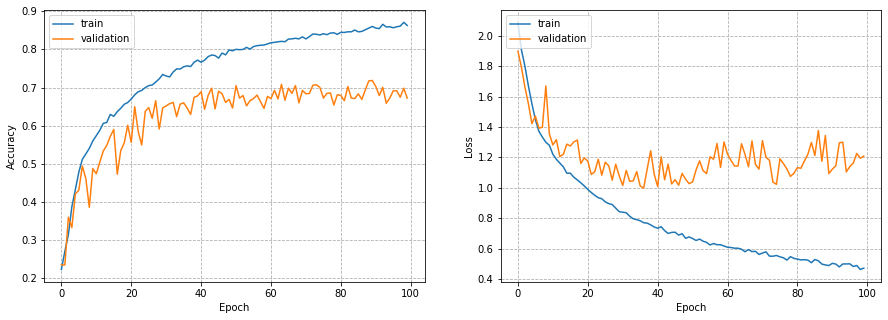

	Max validation accuracy: 71.8468 %
	Min validation loss: 0.99784


In [27]:
show_results(history2)

### fold-3 <a name="fold-3"></a>

In [28]:
FOLD_K = 3
REPEAT = 1

history3 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history3.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 10.1622%

Epoch 1/100
244/243 [==============================] - 10s 41ms/step - loss: 2.1087 - accuracy: 0.2158 - val_loss: 1.9886 - val_accuracy: 0.2335
Epoch 2/100
244/243 [==============================] - 10s 41ms/step - loss: 1.8496 - accuracy: 0.3069 - val_loss: 1.8190 - val_accuracy: 0.3859
Epoch 3/100
244/243 [==============================] - 10s 41ms/step - loss: 1.7104 - accuracy: 0.3729 - val_loss: 1.7063 - val_accuracy: 0.4216
Epoch 4/100
244/243 [==============================] - 10s 41ms/step - loss: 1.6095 - accuracy: 0.4189 - val_loss: 1.5826 - val_accuracy: 0.4703
Epoch 5/100
244/243 [==============================] - 10s 43ms/step - loss: 1.5111 - accuracy: 0.4542 - val_loss: 1.5241 - val_accuracy: 0.4649
Epoch 6/100
244/243 [==============================] - 10s 41ms/step - loss: 1.4461 - accuracy: 0.4862 - val_loss: 1.3918 - val_accuracy: 0.5362
Epoch 7/10


(1)


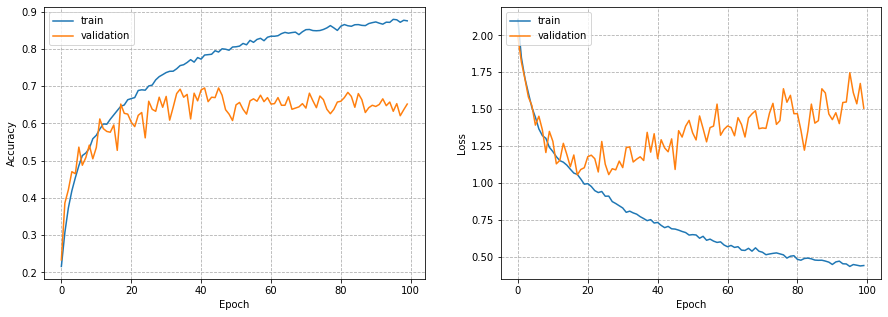

	Max validation accuracy: 69.5135 %
	Min validation loss: 1.05481


In [29]:
show_results(history3)

### fold-4 <a name="fold-4"></a>

In [30]:
FOLD_K = 4
REPEAT = 1

history4 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history4.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 10.8081%

Epoch 1/100
242/241 [==============================] - 10s 42ms/step - loss: 2.0681 - accuracy: 0.2235 - val_loss: 1.9486 - val_accuracy: 0.2596
Epoch 2/100
242/241 [==============================] - 10s 41ms/step - loss: 1.8538 - accuracy: 0.2838 - val_loss: 1.7600 - val_accuracy: 0.3707
Epoch 3/100
242/241 [==============================] - 10s 43ms/step - loss: 1.7129 - accuracy: 0.3599 - val_loss: 1.7088 - val_accuracy: 0.4313
Epoch 4/100
242/241 [==============================] - 10s 42ms/step - loss: 1.5875 - accuracy: 0.4186 - val_loss: 1.5224 - val_accuracy: 0.5020
Epoch 5/100
242/241 [==============================] - 10s 41ms/step - loss: 1.4594 - accuracy: 0.4664 - val_loss: 1.5201 - val_accuracy: 0.4828
Epoch 6/100
242/241 [==============================] - 10s 41ms/step - loss: 1.3928 - accuracy: 0.4978 - val_loss: 1.5095 - val_accuracy: 0.5293
Epoch 7/10


(1)


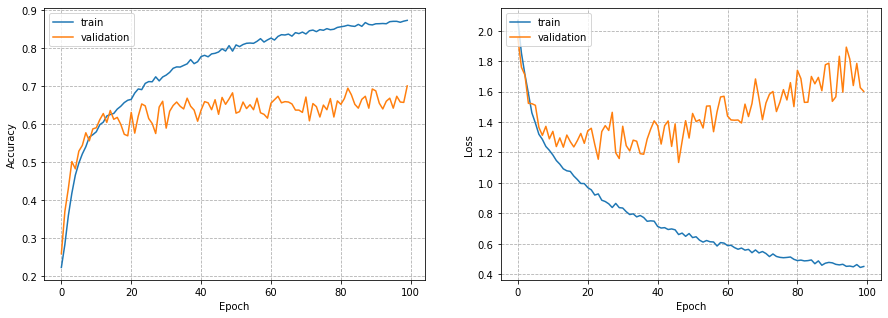

	Max validation accuracy: 70.1010 %
	Min validation loss: 1.13355


In [31]:
show_results(history4)

### fold-5 <a name="fold-5"></a>

In [32]:
FOLD_K = 5
REPEAT = 1

history5 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history5.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 14.9573%

Epoch 1/100
244/243 [==============================] - 10s 42ms/step - loss: 2.0727 - accuracy: 0.2224 - val_loss: 1.9841 - val_accuracy: 0.2650
Epoch 2/100
244/243 [==============================] - 10s 43ms/step - loss: 1.8736 - accuracy: 0.2735 - val_loss: 1.8616 - val_accuracy: 0.3632
Epoch 3/100
244/243 [==============================] - 11s 45ms/step - loss: 1.7510 - accuracy: 0.3456 - val_loss: 1.6841 - val_accuracy: 0.4049
Epoch 4/100
244/243 [==============================] - 10s 43ms/step - loss: 1.6294 - accuracy: 0.4025 - val_loss: 1.4871 - val_accuracy: 0.4156
Epoch 5/100
244/243 [==============================] - 10s 42ms/step - loss: 1.5093 - accuracy: 0.4541 - val_loss: 1.5251 - val_accuracy: 0.4594
Epoch 6/100
244/243 [==============================] - 11s 43ms/step - loss: 1.4106 - accuracy: 0.4964 - val_loss: 1.3159 - val_accuracy: 0.4850
Epoch 7/10


(1)


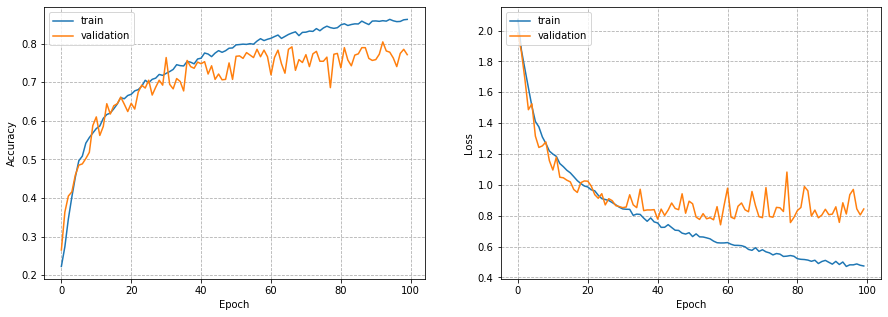

	Max validation accuracy: 80.4487 %
	Min validation loss: 0.74084


In [33]:
show_results(history5)

### fold-6 <a name="fold-6"></a>

In [34]:
FOLD_K = 6
REPEAT = 1

history6 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history6.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 13.0012%

Epoch 1/100
248/247 [==============================] - 10s 41ms/step - loss: 2.0831 - accuracy: 0.2235 - val_loss: 1.9002 - val_accuracy: 0.2855
Epoch 2/100
248/247 [==============================] - 10s 41ms/step - loss: 1.9173 - accuracy: 0.2588 - val_loss: 1.8165 - val_accuracy: 0.2989
Epoch 3/100
248/247 [==============================] - 10s 41ms/step - loss: 1.8124 - accuracy: 0.3117 - val_loss: 1.7709 - val_accuracy: 0.3402
Epoch 4/100
248/247 [==============================] - 10s 41ms/step - loss: 1.6966 - accuracy: 0.3523 - val_loss: 1.6361 - val_accuracy: 0.3706
Epoch 5/100
248/247 [==============================] - 10s 41ms/step - loss: 1.6020 - accuracy: 0.3976 - val_loss: 1.5109 - val_accuracy: 0.4265
Epoch 6/100
248/247 [==============================] - 10s 42ms/step - loss: 1.5254 - accuracy: 0.4362 - val_loss: 1.3793 - val_accuracy: 0.5176
Epoch 7/10


(1)


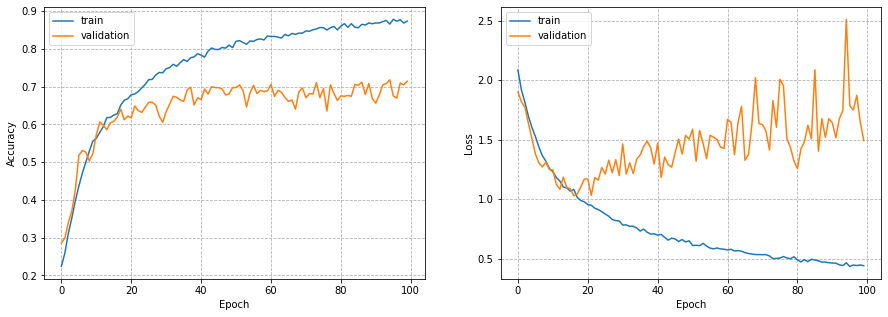

	Max validation accuracy: 71.8104 %
	Min validation loss: 1.02665


In [35]:
show_results(history6)

### fold-7 <a name="fold-7"></a>

In [36]:
FOLD_K = 7
REPEAT = 1

history7 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history7.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 13.1265%

Epoch 1/100
247/246 [==============================] - 10s 42ms/step - loss: 2.0731 - accuracy: 0.2221 - val_loss: 1.9316 - val_accuracy: 0.3174
Epoch 2/100
247/246 [==============================] - 10s 40ms/step - loss: 1.8943 - accuracy: 0.2834 - val_loss: 1.9635 - val_accuracy: 0.2375
Epoch 3/100
247/246 [==============================] - 10s 41ms/step - loss: 1.7626 - accuracy: 0.3366 - val_loss: 1.7368 - val_accuracy: 0.3699
Epoch 4/100
247/246 [==============================] - 10s 41ms/step - loss: 1.6426 - accuracy: 0.3982 - val_loss: 1.6141 - val_accuracy: 0.4570
Epoch 5/100
247/246 [==============================] - 10s 40ms/step - loss: 1.5272 - accuracy: 0.4467 - val_loss: 1.5468 - val_accuracy: 0.4558
Epoch 6/100
247/246 [==============================] - 10s 40ms/step - loss: 1.4640 - accuracy: 0.4777 - val_loss: 1.5297 - val_accuracy: 0.4726
Epoch 7/10


(1)


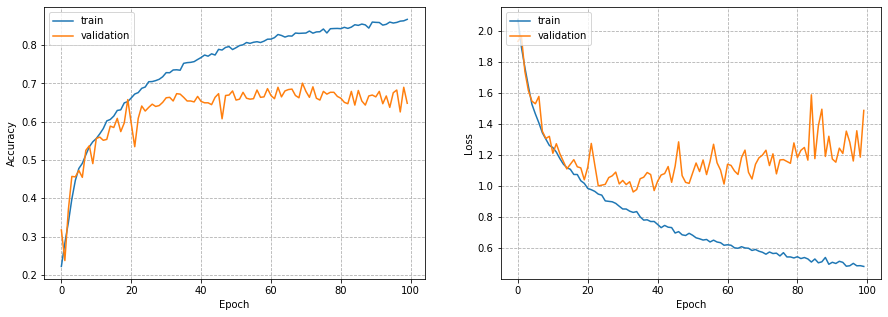

	Max validation accuracy: 70.0477 %
	Min validation loss: 0.96175


In [37]:
show_results(history7)

### fold-8 <a name="fold-8"></a>

In [38]:
FOLD_K = 8
REPEAT = 1

history8 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history8.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 9.4293%

Epoch 1/100
248/247 [==============================] - 10s 42ms/step - loss: 2.1113 - accuracy: 0.2194 - val_loss: 1.9106 - val_accuracy: 0.2283
Epoch 2/100
248/247 [==============================] - 10s 42ms/step - loss: 1.8874 - accuracy: 0.2941 - val_loss: 1.6618 - val_accuracy: 0.3809
Epoch 3/100
248/247 [==============================] - 10s 41ms/step - loss: 1.7201 - accuracy: 0.3735 - val_loss: 1.6236 - val_accuracy: 0.4107
Epoch 4/100
248/247 [==============================] - 10s 41ms/step - loss: 1.6126 - accuracy: 0.4027 - val_loss: 1.4225 - val_accuracy: 0.4913
Epoch 5/100
248/247 [==============================] - 10s 41ms/step - loss: 1.4911 - accuracy: 0.4599 - val_loss: 1.2990 - val_accuracy: 0.4938
Epoch 6/100
248/247 [==============================] - 10s 41ms/step - loss: 1.4066 - accuracy: 0.4984 - val_loss: 1.4598 - val_accuracy: 0.5037
Epoch 7/100


(1)


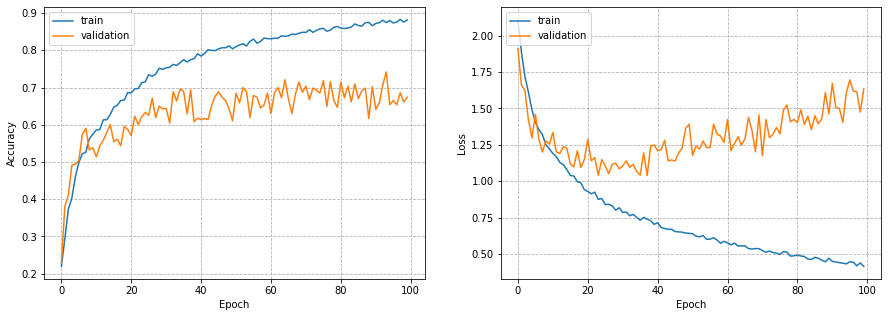

	Max validation accuracy: 74.1935 %
	Min validation loss: 1.03979


In [39]:
show_results(history8)

### fold-9 <a name="fold-9"></a>

In [40]:
FOLD_K = 9
REPEAT = 1

history9 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history9.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 5.6373%

Epoch 1/100
248/247 [==============================] - 10s 40ms/step - loss: 2.0925 - accuracy: 0.2213 - val_loss: 1.8308 - val_accuracy: 0.2843
Epoch 2/100
248/247 [==============================] - 10s 40ms/step - loss: 1.9048 - accuracy: 0.2740 - val_loss: 1.6679 - val_accuracy: 0.3529
Epoch 3/100
248/247 [==============================] - 10s 42ms/step - loss: 1.7443 - accuracy: 0.3517 - val_loss: 1.6095 - val_accuracy: 0.3615
Epoch 4/100
248/247 [==============================] - 10s 41ms/step - loss: 1.5884 - accuracy: 0.4279 - val_loss: 1.5297 - val_accuracy: 0.4436
Epoch 5/100
248/247 [==============================] - 10s 41ms/step - loss: 1.4769 - accuracy: 0.4698 - val_loss: 1.4539 - val_accuracy: 0.4473
Epoch 6/100
248/247 [==============================] - 10s 41ms/step - loss: 1.3970 - accuracy: 0.5035 - val_loss: 1.3238 - val_accuracy: 0.4926
Epoch 7/100


(1)


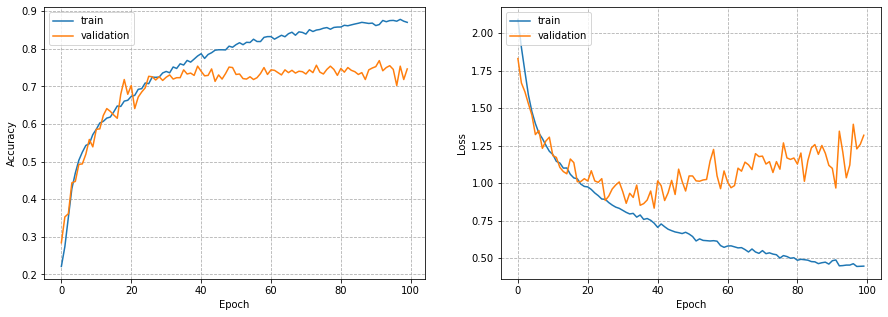

	Max validation accuracy: 76.8382 %
	Min validation loss: 0.83280


In [41]:
show_results(history9)

### fold-10 <a name="fold-10"></a>

In [42]:
FOLD_K = 10
REPEAT = 1

history10 = []

for i in range(REPEAT): 
    print('-'*80)
    print("\n({})\n".format(i+1))
    
    history = process_fold(FOLD_K, us8k_df, epochs=100)
    history10.append(history)

--------------------------------------------------------------------------------

(1)

Pre-training accuracy: 3.3453%

Epoch 1/100
247/246 [==============================] - 10s 41ms/step - loss: 2.0758 - accuracy: 0.2180 - val_loss: 1.8123 - val_accuracy: 0.2640
Epoch 2/100
247/246 [==============================] - 10s 40ms/step - loss: 1.8572 - accuracy: 0.2866 - val_loss: 1.7000 - val_accuracy: 0.3513
Epoch 3/100
247/246 [==============================] - 10s 41ms/step - loss: 1.7047 - accuracy: 0.3516 - val_loss: 1.5606 - val_accuracy: 0.4050
Epoch 4/100
247/246 [==============================] - 10s 39ms/step - loss: 1.5961 - accuracy: 0.3965 - val_loss: 1.4558 - val_accuracy: 0.4552
Epoch 5/100
247/246 [==============================] - 10s 39ms/step - loss: 1.4946 - accuracy: 0.4533 - val_loss: 1.3869 - val_accuracy: 0.4421
Epoch 6/100
247/246 [==============================] - 10s 40ms/step - loss: 1.4092 - accuracy: 0.4846 - val_loss: 1.2565 - val_accuracy: 0.5615
Epoch 7/100


(1)


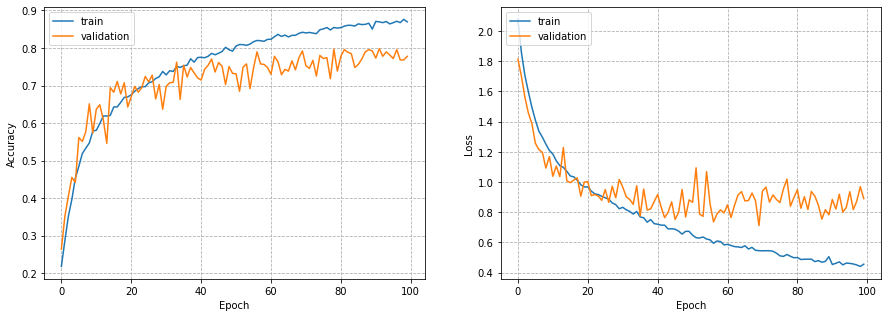

	Max validation accuracy: 79.8088 %
	Min validation loss: 0.71224


In [43]:
show_results(history10)

---

## 5. Results  <a name="fifth-bullet"></a>

### 10-fold cross validation:

|fold|accuracy| loss
|---|:-:|:-:|
|fold-1| 0.82|0.739|
|fold-2|0.72|0.998|
|fold-3|0.70|1.055|
|fold-4|0.70|1.134|
|fold-5|0.80|0.741|
|fold-6|0.72|1.027|
|fold-7|0.70|0.962|
|fold-8|0.74|1.040|
|fold-9|0.77|0.833|
|fold-10|0.80|0.713|
|**Total**|**0.75**|**0.924**| 